# ch37.[실습37] Wine 품질 데이터 분석과 품질 예측

### 데이터 분석 목적 
    - Wine 품질에 영향을 미치는 요소를 확인해 품질 개선을 시도한다

### Key Point
    - categorical, numeric 데이터를 분석하는 방법과
    - 변수들과의 교호 작용을 파악하는 통계적 검정 방법을 배운다
    - 데이터 처리 시에 고려해야 하는 것들에 대해 자세히 배운다
    - 불균형 데이터를 처리하기 위한 다양한 방법을 배운다 
    - 모델을 활용해 독립 변수의 종속 변수에 대한 영향도를 파악하는 방법을 배운다


In [1]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
import pandas_profiling
from datetime import datetime

# library for statistic
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import boxcox, norm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats.mstats import kruskal
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV

# library for sampling 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

from xgboost import XGBClassifier
from xgboost import plot_importance

c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  if __name__ == "__main__":


## 1. Data Processing 1 

### 1-1 Data Load 

In [2]:
df = pd.read_csv("Data/winequality.csv")
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
df.columns

Index(['type', 'fixed acidity', 'volatile acidity', 'citric acid',
       'residual sugar', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol',
       'quality'],
      dtype='object')

### 1-2 Duplicated Data 확인

In [4]:
print("중복된 항목 수 :", len(df[df.duplicated()])) 

중복된 항목 수 : 1168


In [5]:
# duplicate data 제거
df = df[~df.duplicated()]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5329 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5329 non-null   object 
 1   fixed acidity         5319 non-null   float64
 2   volatile acidity      5321 non-null   float64
 3   citric acid           5326 non-null   float64
 4   residual sugar        5327 non-null   float64
 5   chlorides             5327 non-null   float64
 6   free sulfur dioxide   5329 non-null   float64
 7   total sulfur dioxide  5329 non-null   float64
 8   density               5329 non-null   float64
 9   pH                    5320 non-null   float64
 10  sulphates             5325 non-null   float64
 11  alcohol               5329 non-null   float64
 12  quality               5329 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 582.9+ KB


In [7]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
6,white,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6


In [8]:
# reset index
df = df.reset_index(drop=True).copy()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5329 non-null   object 
 1   fixed acidity         5319 non-null   float64
 2   volatile acidity      5321 non-null   float64
 3   citric acid           5326 non-null   float64
 4   residual sugar        5327 non-null   float64
 5   chlorides             5327 non-null   float64
 6   free sulfur dioxide   5329 non-null   float64
 7   total sulfur dioxide  5329 non-null   float64
 8   density               5329 non-null   float64
 9   pH                    5320 non-null   float64
 10  sulphates             5325 non-null   float64
 11  alcohol               5329 non-null   float64
 12  quality               5329 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 541.4+ KB


In [10]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6


## 2. Data EDA

### 2-1 Data Type and Summary

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5329 entries, 0 to 5328
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5329 non-null   object 
 1   fixed acidity         5319 non-null   float64
 2   volatile acidity      5321 non-null   float64
 3   citric acid           5326 non-null   float64
 4   residual sugar        5327 non-null   float64
 5   chlorides             5327 non-null   float64
 6   free sulfur dioxide   5329 non-null   float64
 7   total sulfur dioxide  5329 non-null   float64
 8   density               5329 non-null   float64
 9   pH                    5320 non-null   float64
 10  sulphates             5325 non-null   float64
 11  alcohol               5329 non-null   float64
 12  quality               5329 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 541.4+ KB


In [12]:
df.isna().sum().sort_values(ascending=False)

fixed acidity           10
pH                       9
volatile acidity         8
sulphates                4
citric acid              3
residual sugar           2
chlorides                2
type                     0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
alcohol                  0
quality                  0
dtype: int64

In [13]:
# categorical and numeric columns
for column_name in list(df.columns):
    print(column_name, df[column_name].dtype, df[column_name].unique())

type object ['white' 'red']
fixed acidity float64 [ 7.    6.3   8.1   7.2   6.2   8.6   7.9   6.6   8.3    nan  7.4   6.5
  6.4   6.8   7.6   6.9   8.5   5.8   7.3   6.7   6.    7.1   6.1   7.5
  9.8   5.5   5.9   7.8   5.7   8.2   5.6   5.2   8.4  10.2   7.7   5.3
  5.4   9.1   5.    8.   10.    5.1   9.2   9.    8.8   8.7   4.8  10.3
  9.4   9.6   9.3   8.9   9.7  10.7  14.2   9.9   9.5  11.8   4.6   6.15
  4.5   7.15  6.45  4.2   4.9   4.7   3.8   4.4   3.9  11.2  10.1  11.5
 12.8  11.   11.6  12.   15.   10.8  11.1  12.5  10.9  11.4  10.4  13.3
 10.6  13.4  11.9  12.4  12.2  13.8  13.5  10.5  12.6  14.   13.7  12.7
 12.3  15.6  11.3  13.   12.9  14.3  15.5  11.7  13.2  15.9  12.1 ]
volatile acidity float64 [0.27  0.3   0.28  0.23  0.32  0.22  0.18  0.16  0.42  0.17  0.48  0.66
 0.34  0.31  0.26  0.67  0.25  0.24  0.14  0.12  0.39  0.33  0.45  0.46
 0.19  0.2   0.21  0.38  0.47  0.35  0.54  0.43  0.44    nan 0.265 0.36
 0.305 0.13  0.41  0.485 0.425 0.37  0.255 0.595 0.29  0.53  0.1

In [14]:
list_categorical_columns = list(df.select_dtypes(include=['object']).columns)
list_numeric_columns = list(df.select_dtypes(include=['float64']).columns)
target_column = "quality"
print(len(df.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

13
1
11


In [15]:
# 결측치 확인 필요
df.isna().sum().sort_values(ascending=False)

fixed acidity           10
pH                       9
volatile acidity         8
sulphates                4
citric acid              3
residual sugar           2
chlorides                2
type                     0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
alcohol                  0
quality                  0
dtype: int64

#### Summary of Data Set
##### - Number of Variables : 13
    categorical variables : 1 (wine type)
    numeric variables : 11
    target variables : 1
##### - Number of observations : 6497 (duplicate row 제거시 5329)
##### - Missing Cells : 7 columns
##### - Duplicated Rows : 1168 

### 2-2 Dependent(종속) Data Explore

In [16]:
df[target_column].value_counts()

6    2327
5    1755
7     857
4     206
8     149
3      30
9       5
Name: quality, dtype: int64

<AxesSubplot:xlabel='quality', ylabel='count'>

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


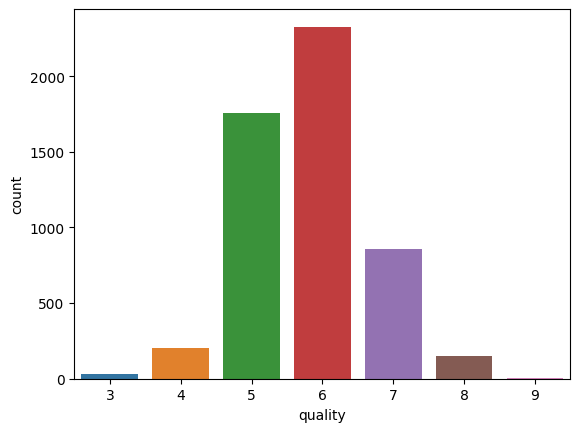

In [17]:
sns.countplot(x=target_column, data=df)

#### Imbalance data set?
  - target class 간의 비중 차이가 있다. 독립 변수가 categorical 이 포함된 경우는 one-hot encoding을 진행한 뒤에 sampling 을 해야 한다.
  - ML 학습시 cost-sensitive (class weight 등)을 활용할 수 있다.

##### 1. 데이터 기반 접근 방법
    - Sampling (over sampling 혹은 under sampling)
    (이번 실습에서는 oversampling 중에서 SMOTE과 ADASYN 2가지 활용)
    https://imbalanced-learn.org/stable/references/index.html#api
##### 2. ML 알고리즘 기반 접근 방법
    - ML 알고리즘 활용 -> ML 학습 시에 class weight를 활용하여 cost-sensitive learning 
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### 2-3 Independent(독립) Data Explore

#### 1) Categorical Data Analysis

##### 불필요한 컬럼 제거

In [18]:
df[list_categorical_columns].nunique().sort_values()

type    2
dtype: int64

##### Column별 분포 확인

<AxesSubplot:xlabel='type', ylabel='count'>

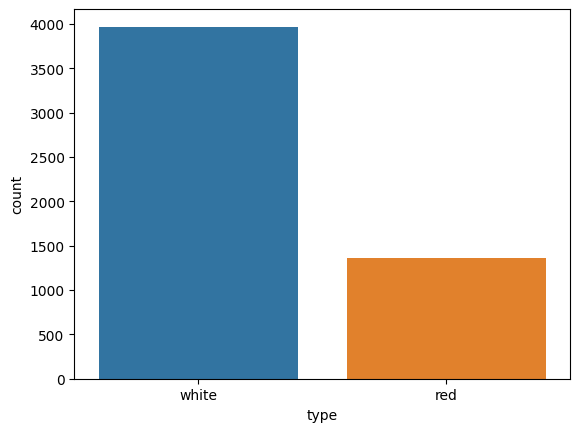

In [19]:
sns.countplot(x=df[list_categorical_columns[0]])

##### Target column과 categorical column 관계 분포 확인

<AxesSubplot:xlabel='quality'>

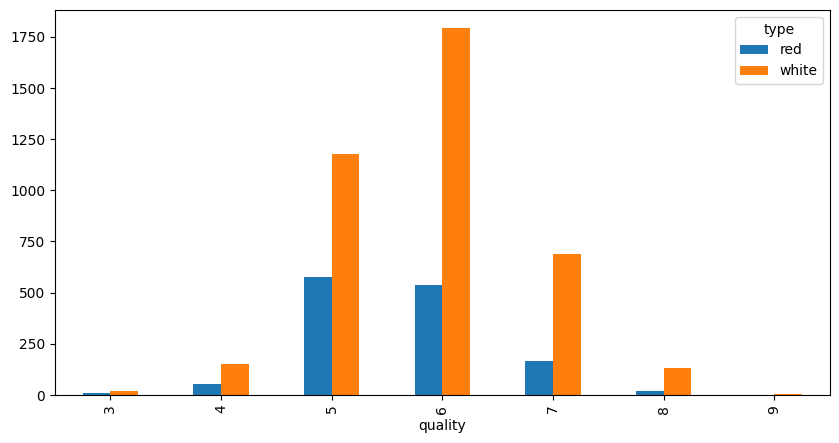

In [20]:
df_target_categorical = pd.crosstab(df[target_column], df[list_categorical_columns[0]])
df_target_categorical.plot.bar(figsize=(10,5))

# 애초에 type간의 비중이 다르기 때문에, wine type에 따른 quality 데이터 분포를 아래와 같은 plot으로는 분석하기 어려움.
# 이런 경우에는 비율 데이터를 plot으로 그리면 데이터 분포 이해에 도움.

In [21]:
df_target_categorical

type,red,white
quality,,
3,10,20
4,53,153
5,577,1178
6,535,1792
7,167,690
8,17,132
9,0,5


<AxesSubplot:xlabel='quality'>

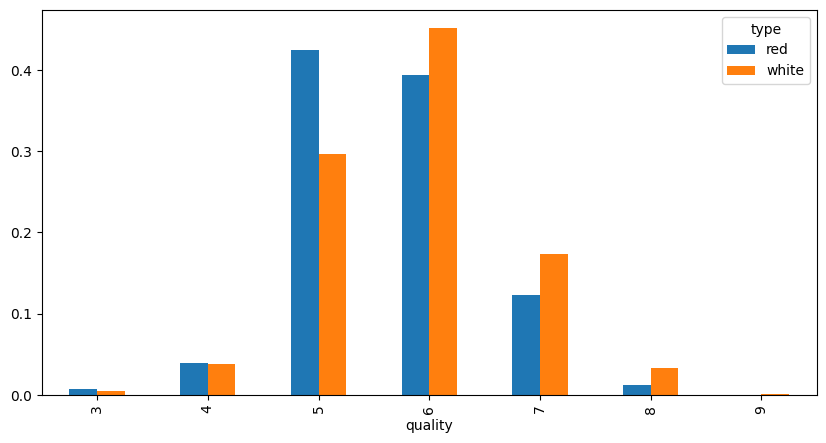

In [22]:
# 각 wine type별 quality 비율 
df_target_categorical_ratio = pd.crosstab(df[target_column], df[list_categorical_columns[0]], normalize="columns")
df_target_categorical_ratio.plot.bar(figsize=(10,5))

# white wine이 red wine보다 높은 quality(quality 6,7,8,9) 에 속하는 비율이 큼 

##### 카이제곱 검정 (chisqaure-test)
*   카이제곱 검정은 두 범주형 변수에 대한 분석 방법. 
*   예를 들어, 성별에 따른 선호 영화 장르 비교 문제.
*   본 실습에서는 독립 변수중의 wine quality 와 wine type 간의 관계를 검증. 
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/카이제곱_검정



##### 카이제곱 검정 추가 설명 : 3가지 유형
1.   적합도 검정 (Goodness of fit)
  - 변수 1개
  - 기존에 알려준 기준이 존재하는 검정 
  - 예시) 상자 안에 공 3개가 같은 비율로 알려져 있음. 공 100개를 뽑았을 때, 각 색의 비율이 구해짐. -> 기존에 알려진 공 비율 분포를 따르는지 검정
  - 귀무가설 : 변수 X의 관측분포와 기대 분포가 동일
  - 대립가설 : 변수 X의 관측분포와 기대분포가 동일하지 않음

2.   독립성 검정 (Test of independence)
  - 변수 2개
  - 범주형 두 변수가 서로 연관되어 있는지 여부를 검정
  - 예시) 성별과 흡연 여부 관계를 알고 싶어서 200명을 추출하여 조사한 경우. 
  - 귀무가설 : 변수 X와 Y는 서로 독립
  - 대립가설 : 변수 X와 Y는 서로 독립이 아님
3.   동질성 검정 (Test of Homogeneity) 
  - 변수 2개
  - 범주형 두 변수의 관계를 알기 위한 검정은 아님
  - 각 그룹들이 동질한지 알고 싶은 검정
  - 예시) 남자와 여자 흡연율 차이가 있는지 흡연율을 조사한 후, 두 그룹의 흡연율이 같은지 여부를 검정
  - 귀무가설 : 각 그룹의 확률분포가 동일
  - 대립가설 : 각 그룹의 확률분포가 동일하지 않음




In [23]:
list_meaningful_column_by_chi = []
for column_name in list_categorical_columns:
  statistic, pvalue, _, _ = chi2_contingency(pd.crosstab(df[target_column], df[column_name]))
  if pvalue <= 0.05:
    list_meaningful_column_by_chi.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by chi : ", len(list_meaningful_column_by_chi), list_meaningful_column_by_chi)

type ,  92.55757660117322 ,  8.909935054561511e-18
all categorical columns :  1
selected columns by chi :  1 ['type']


##### Insight
1.   quality(종속 변수)와 type(wine)은 유의미한 관계를 갖음 
2.   white wine이 quality가 높은 경향을 보임 (quality 6,7,8,9 비율이 높음)


#### 2) Numeric Data Analysis

##### 불필요한 컬럼 제거

In [24]:
df[list_numeric_columns].nunique().sort_values()

citric acid              89
fixed acidity           106
pH                      108
sulphates               111
alcohol                 111
free sulfur dioxide     135
volatile acidity        187
chlorides               214
total sulfur dioxide    276
residual sugar          316
density                 998
dtype: int64

##### Column별 분포 확인

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


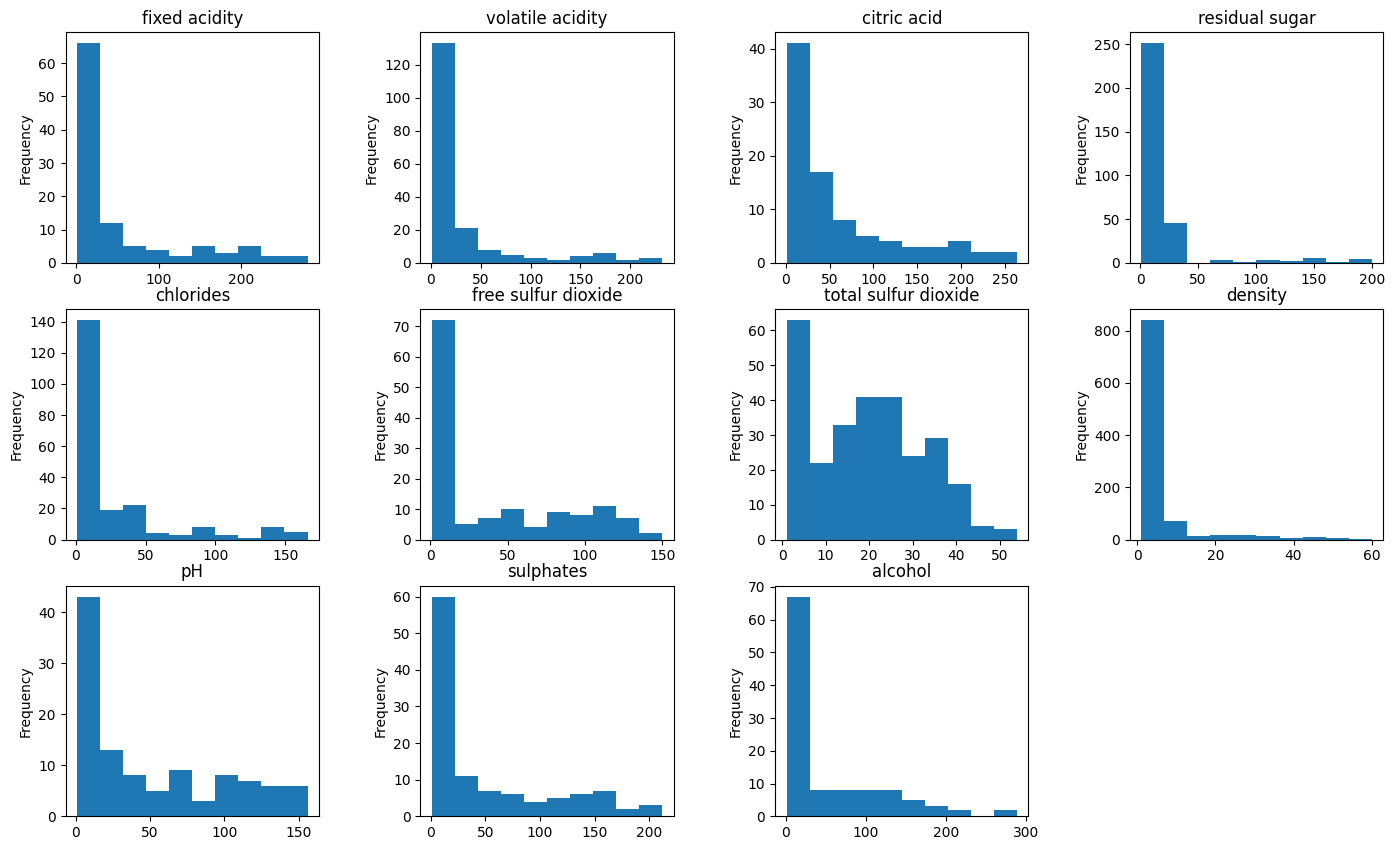

In [25]:
# numeric column 별 분포 확인 
plt.figure(figsize=(17,8))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.4)
for column_name in list_numeric_columns:
    plt.subplot(3,4,x)
    x = x+1
    df[column_name].value_counts().plot(kind='hist')
    plt.title(column_name)
plt.show()

In [26]:
for column_name in list_numeric_columns:
  df_tmp = df[column_name].dropna()
  print(column_name, "skew : ", skew(df_tmp), "kur : ", kurtosis(df_tmp))
  
# 추후 scaling을 활용한 feature preprocessing의 필요성 확인 -> 이번 실습에서는 standardization이 아닌 box-cox transformation을 진행 예정

fixed acidity skew :  1.649973971310544 kur :  4.58780963914448
volatile acidity skew :  1.5046286118095213 kur :  2.861054035331226
citric acid skew :  0.48424924939452224 kur :  2.575252366037958
residual sugar skew :  1.7022547514940163 kur :  6.978512605998949
chlorides skew :  5.339461483688544 kur :  48.263884477368336
free sulfur dioxide skew :  1.3582571378203268 kur :  9.463405122228282
total sulfur dioxide skew :  0.061679285863074126 kur :  -0.30336748319239026
density skew :  0.6645636642660108 kur :  8.683915901102884
pH skew :  0.39110488738209526 kur :  0.43478434967846846
sulphates skew :  1.8086986354241874 kur :  8.60364762791347
alcohol skew :  0.545991744487456 kur :  -0.5388265936888592


##### Correlation Analysis

<AxesSubplot:>

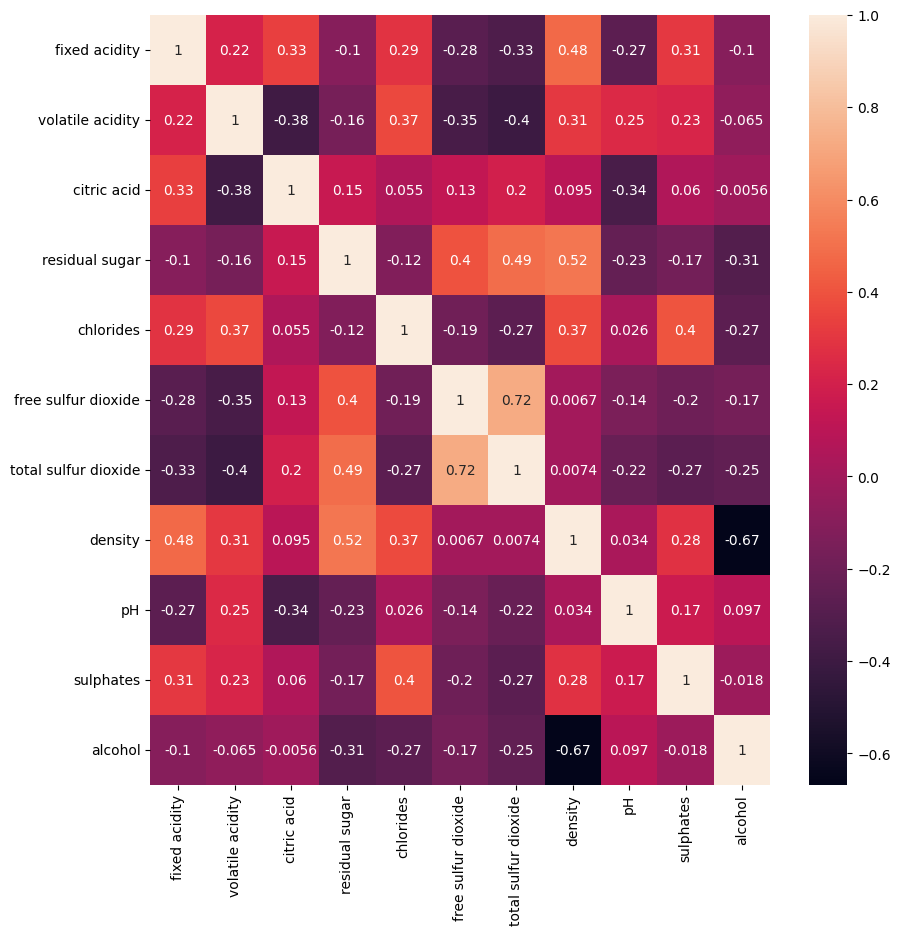

In [27]:
df_corr = df[list_numeric_columns].corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_corr, annot=True)

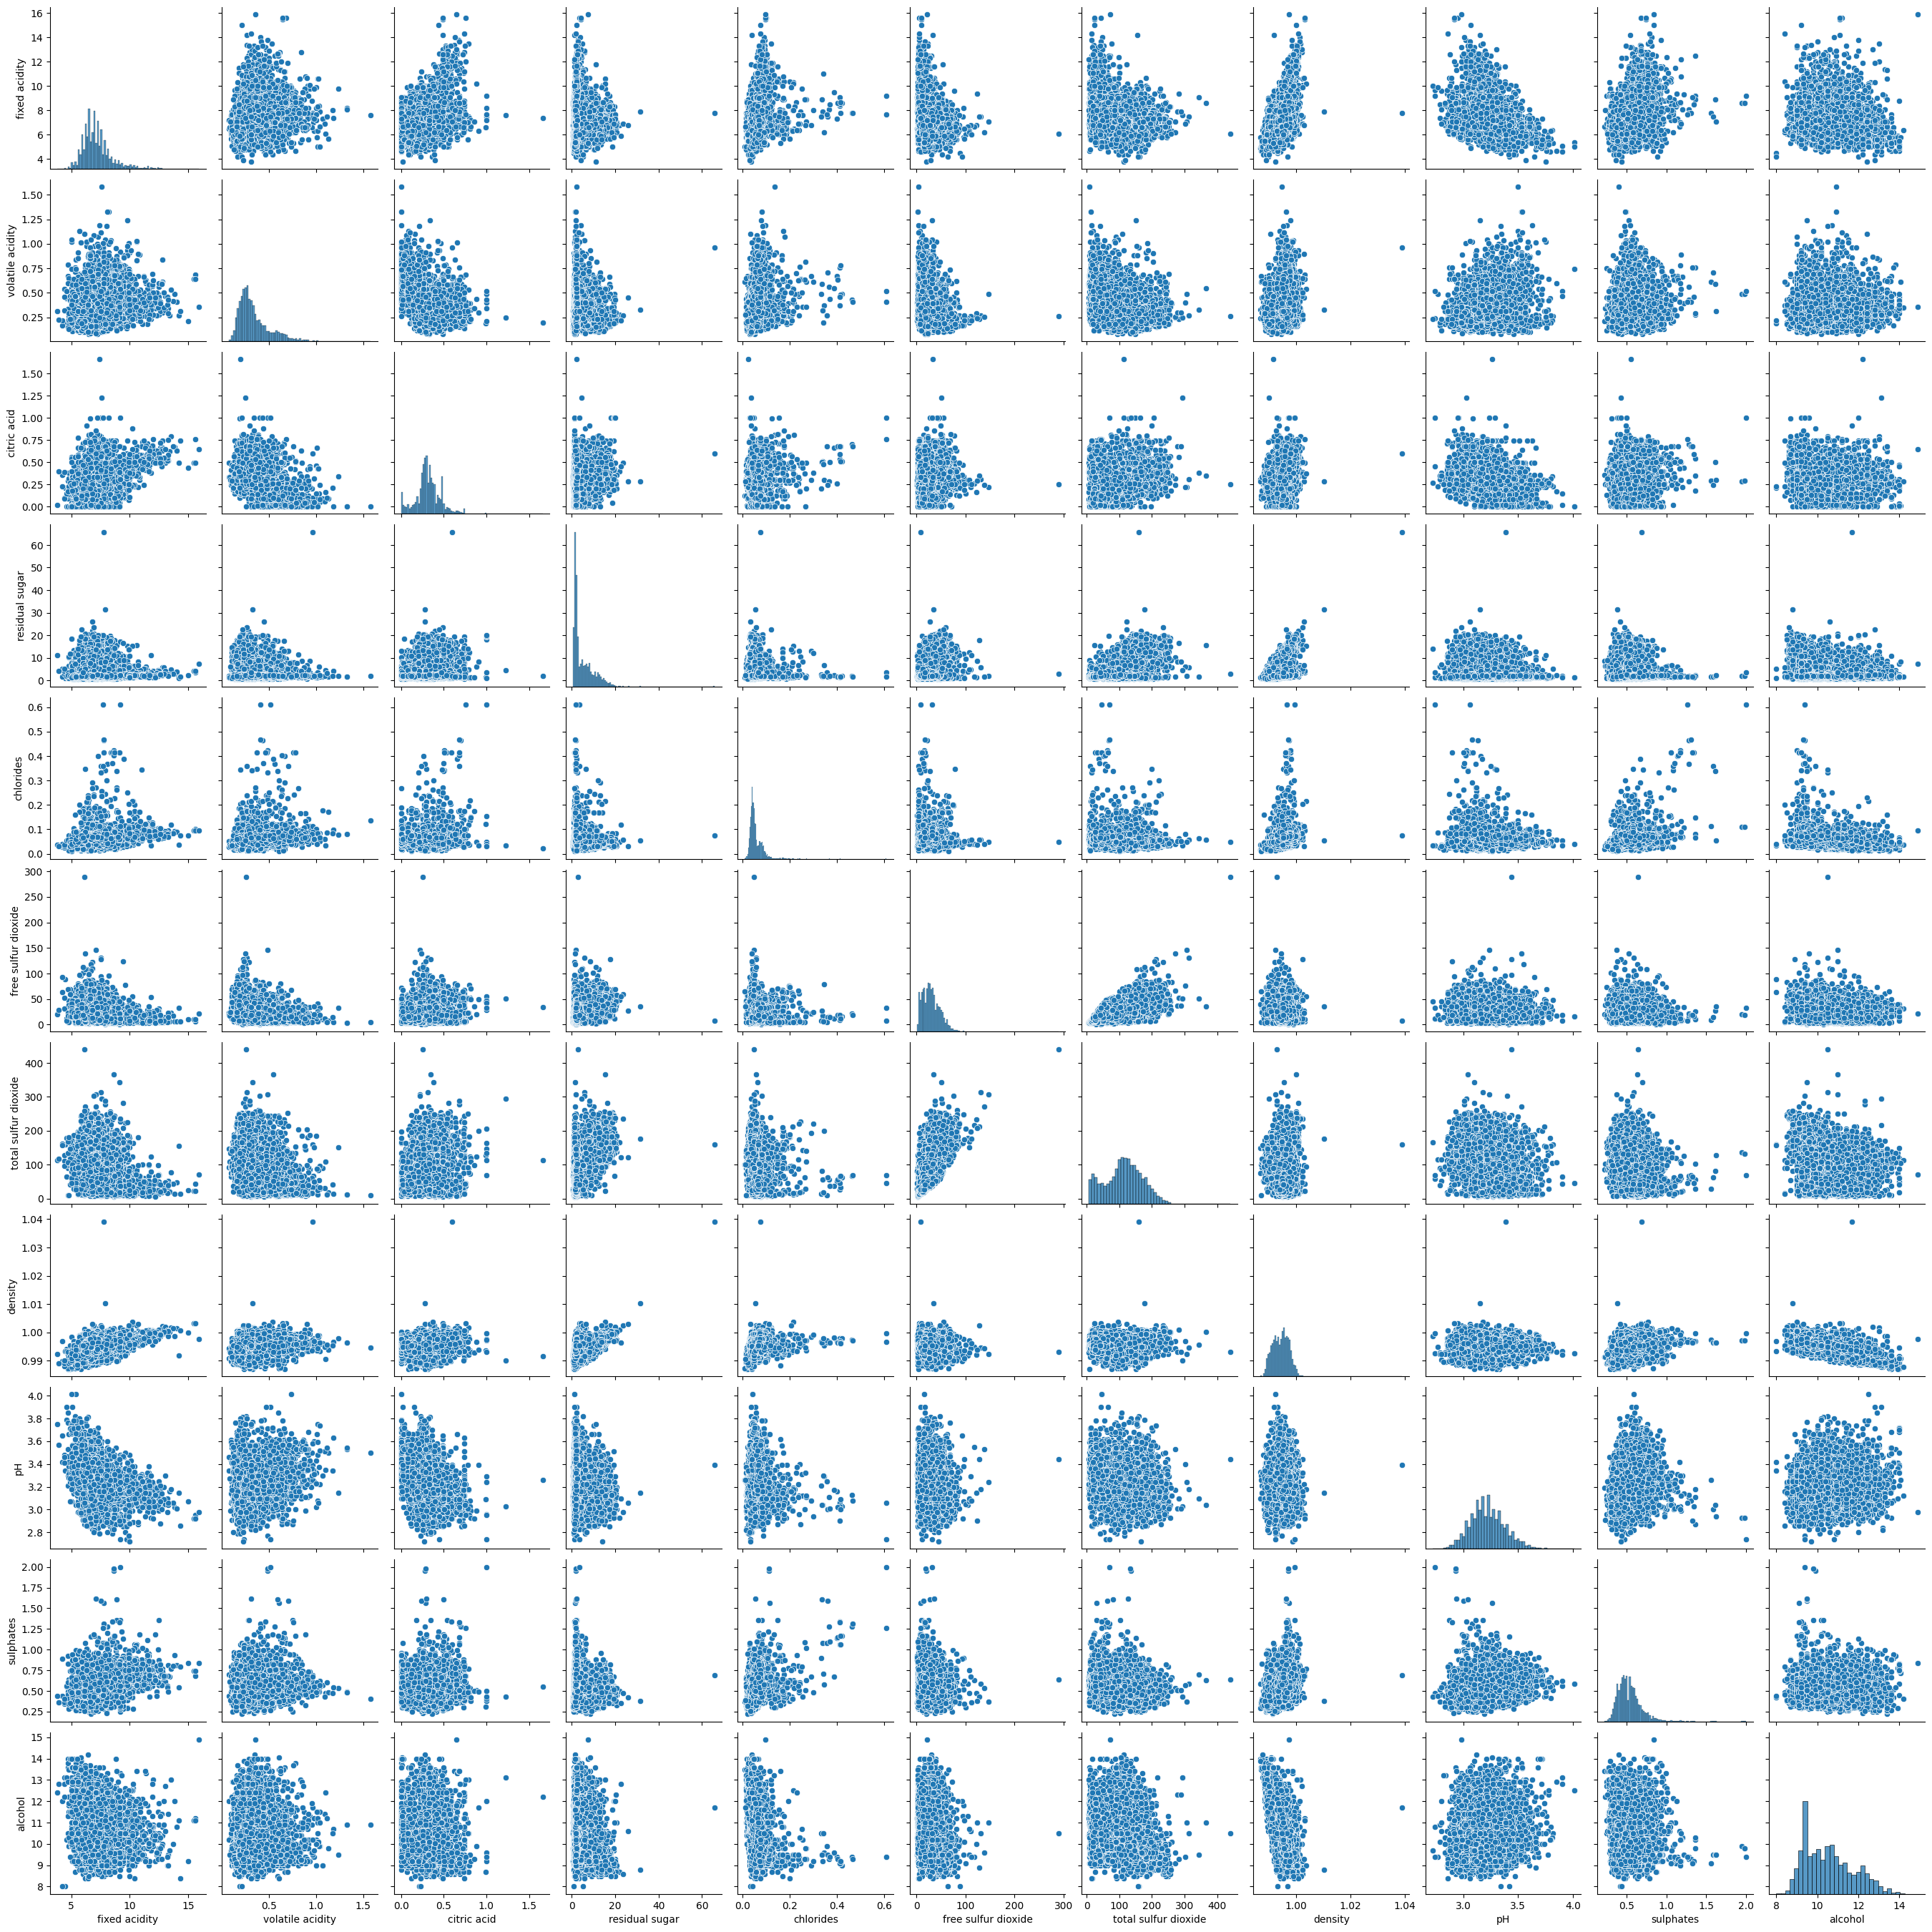

In [28]:
sns.pairplot(df[list_numeric_columns])

# alcohol과 density가 -0.67로 높은 상관관계를 보이는 것 같으나, scatterplot에서 한계가 있다고 판단.
# 즉, 상대적으로 높은 상관관계를 갖는 것이 없는것으로 보여 다중공선성을 일으킬 변수는 없다고 판단하며 VIF 분석 하지 않음.

##### Target Column과 numeric Column 관계 분포 확인

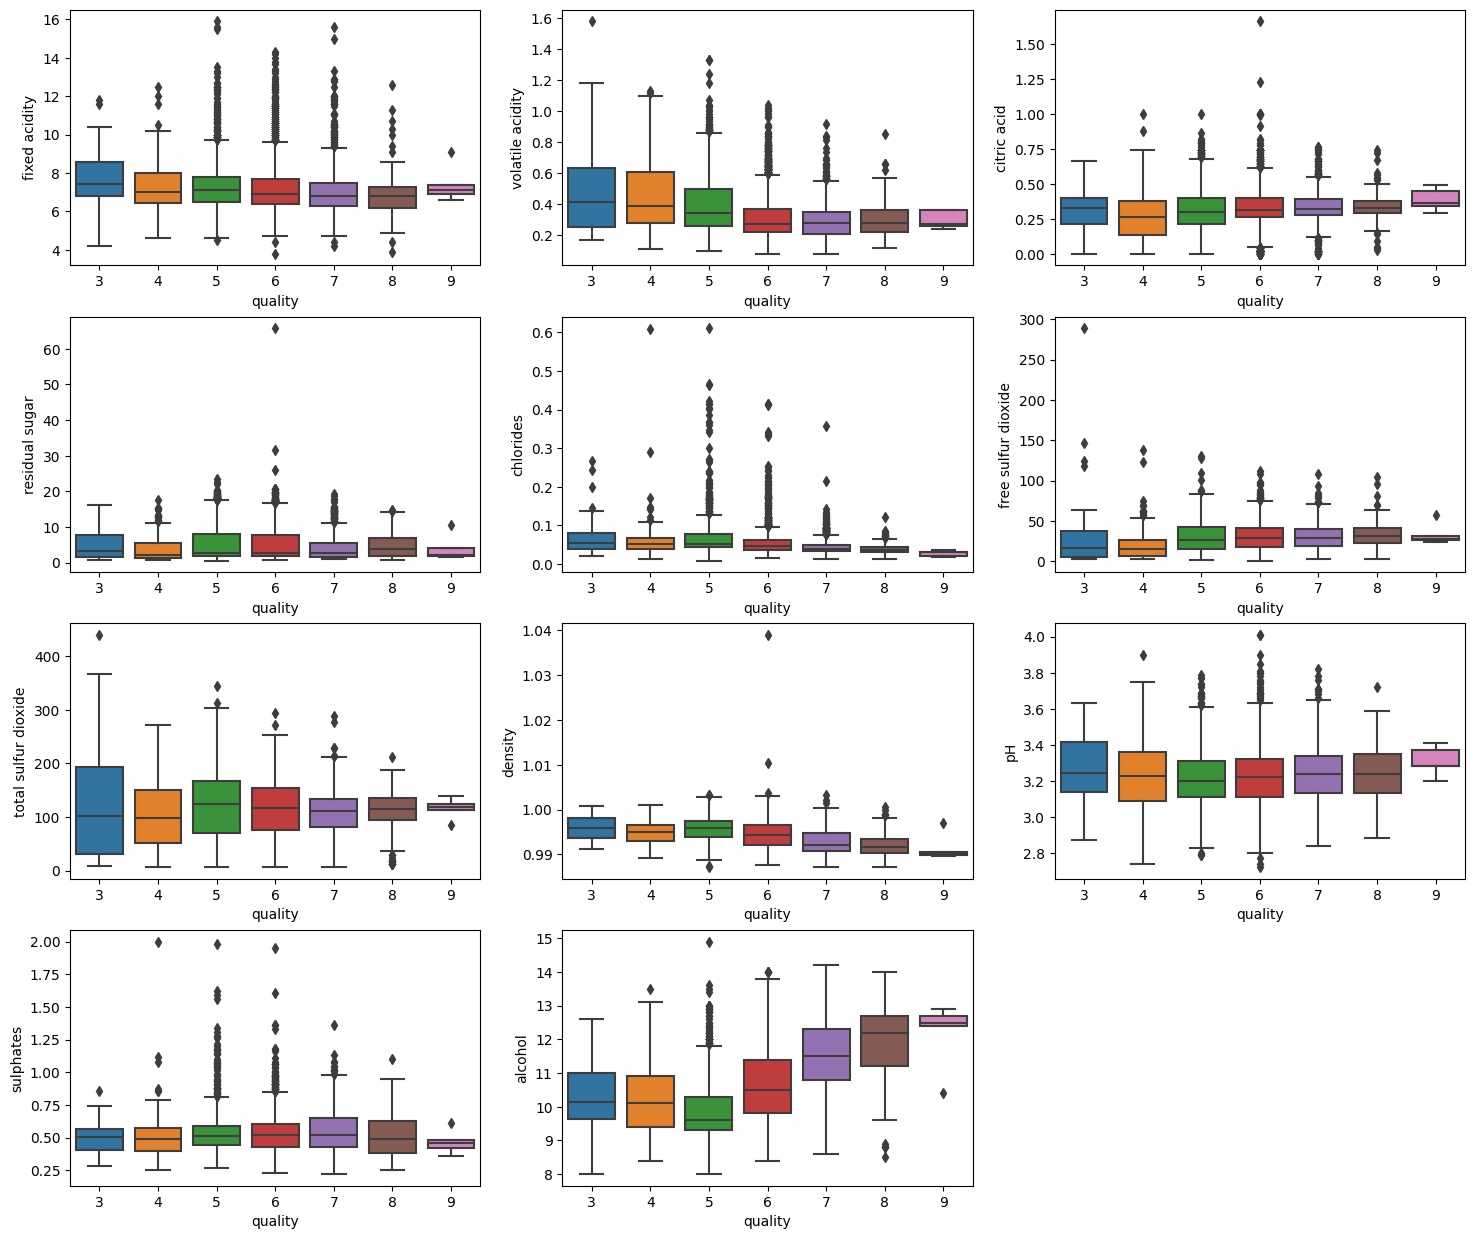

In [29]:
plt.figure(figsize=(18,12))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.2, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(4,3,x)
    x = x + 1
    sns.boxplot(data=df,x=target_column,y=column_name)
plt.show()

# 가장 눈에 띄는 것은 alcohol 분포에 따른 quality 차이 
# fixed acidity와 total sulfur dioxide도 눈에 띄는 차이가 보임

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 quality 에 따른 numeric column data 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)





정규성 검정
*   귀무가설 : 모집단의 분포는 정규 분포이다
*   검정 방법 : Shpiro-Wilks Test
*   p-value < 0.05이면, 귀무가설 기각 (기각하지 못하여야 정규성을 만족)



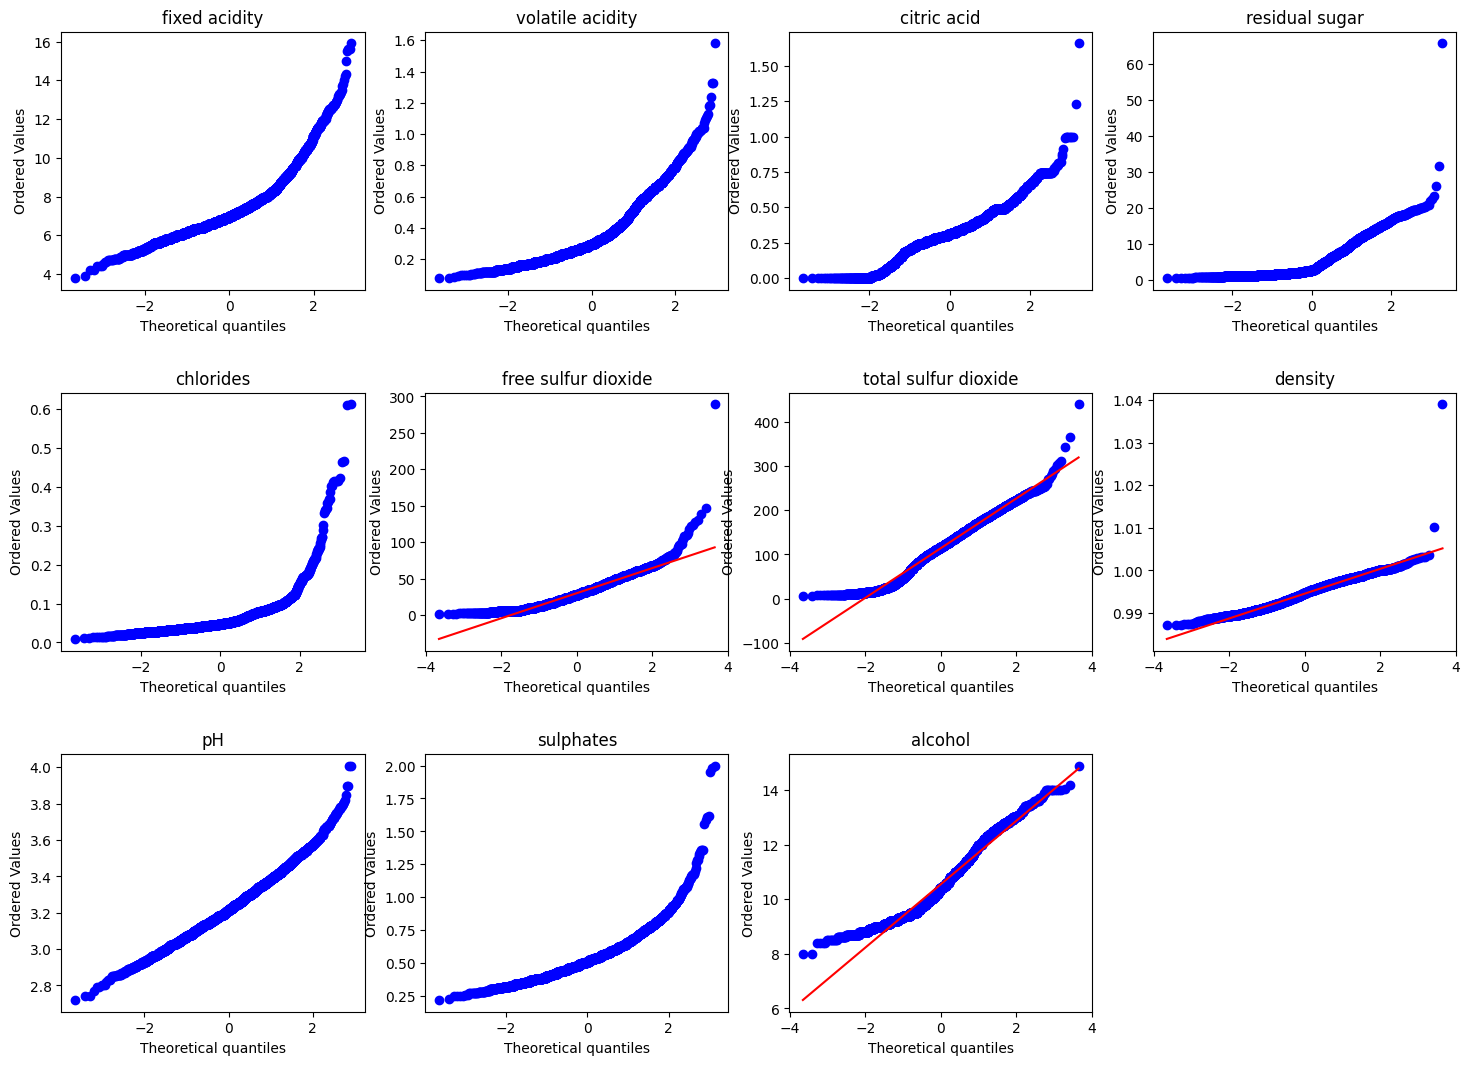

In [30]:
# numeric column 정규성 확인
plt.figure(figsize=(18,10))
x = 1
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.4, wspace=0.2)
for column_name in list_numeric_columns:
    plt.subplot(3,4,x)
    x = x+1
    stats.probplot(df[column_name], dist=stats.norm, plot=plt)
    plt.title(column_name)
plt.show()

In [31]:
list_column_normality = []
df_check_norm = df.dropna().copy()
for column_name in list_numeric_columns:
  statistic, pvalue = stats.shapiro(df_check_norm[column_name])
  if pvalue >= 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ",statistic,", pvalue : ", pvalue)
print("정규성 만족하는 column 수 : ", len(list_column_normality))

fixed acidity , statistic :  0.8868133425712585 , pvalue :  0.0
volatile acidity , statistic :  0.8739089965820312 , pvalue :  0.0
citric acid , statistic :  0.9643710851669312 , pvalue :  3.0052027357550265e-34
residual sugar , statistic :  0.8057417869567871 , pvalue :  0.0
chlorides , statistic :  0.6095068454742432 , pvalue :  0.0
free sulfur dioxide , statistic :  0.932924747467041 , pvalue :  1.1210387714598537e-43
total sulfur dioxide , statistic :  0.982937753200531 , pvalue :  8.866042226443555e-25
density , statistic :  0.964694619178772 , pvalue :  4.027879606728051e-34
pH , statistic :  0.9911324381828308 , pvalue :  1.0282730998302828e-17
sulphates , statistic :  0.897512674331665 , pvalue :  0.0
alcohol , statistic :  0.9569287896156311 , pvalue :  5.975748739050237e-37
정규성 만족하는 column 수 :  0


c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


*   raw data는 정규성을 만족하는 데이터가 없음. 
*   이를 보완하기 위해 Transformation 작업을 진행하여 다시 정규성 검정을 진행



In [32]:
# boxcox transformation
list_column_normality = []
for column_name in list_numeric_columns:
  list_positive = df[column_name] > 0
  scaler = StandardScaler()
  statistic, pvalue = stats.shapiro(pd.DataFrame(boxcox(df[list_positive][column_name])[0].reshape(-1,1)))
  if pvalue >= 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ",statistic,", pvalue : ", pvalue)
print("정규성 만족하는 column 수 : ", len(list_column_normality))

fixed acidity , statistic :  0.9893577098846436 , pvalue :  1.3306506839789343e-19
volatile acidity , statistic :  0.9947634339332581 , pvalue :  5.453255577138327e-13
citric acid , statistic :  0.9734329581260681 , pvalue :  5.135708863827308e-30
residual sugar , statistic :  0.9523314237594604 , pvalue :  1.567199730944543e-38
chlorides , statistic :  0.9890493750572205 , pvalue :  6.467643783960575e-20
free sulfur dioxide , statistic :  0.9899816513061523 , pvalue :  5.329335469114036e-19
total sulfur dioxide , statistic :  0.9807549118995667 , pvalue :  2.6984152065515074e-26
density , statistic :  0.9827253222465515 , pvalue :  5.317124153758517e-25
pH , statistic :  0.9993425011634827 , pvalue :  0.04814351350069046
sulphates , statistic :  0.9982933402061462 , pvalue :  1.5025691027403809e-05
alcohol , statistic :  0.9780703186988831 , pvalue :  6.602440294539267e-28
정규성 만족하는 column 수 :  0


c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 50

In [33]:
# boxcox transformation + standardization with standarscaler
list_column_normality = []
for column_name in list_numeric_columns:
  list_positive = df[column_name] > 0
  scaler = StandardScaler()
  statistic, pvalue = stats.shapiro(pd.DataFrame(scaler.fit_transform(boxcox(df[list_positive][column_name])[0].reshape(-1,1))))
  if pvalue >= 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ",statistic,", pvalue : ", pvalue)
print("정규성 만족하는 column 수 : ", len(list_column_normality))

fixed acidity , statistic :  0.9893431067466736 , pvalue :  1.2877427576542773e-19
volatile acidity , statistic :  0.9947795867919922 , pvalue :  5.784247863668823e-13
citric acid , statistic :  0.973427414894104 , pvalue :  5.1037350413267495e-30
residual sugar , statistic :  0.9523282647132874 , pvalue :  1.563666356866748e-38
chlorides , statistic :  0.989020049571991 , pvalue :  6.06411083070997e-20
free sulfur dioxide , statistic :  0.9899801015853882 , pvalue :  5.309790742203056e-19
total sulfur dioxide , statistic :  0.980753481388092 , pvalue :  2.6927545132589645e-26
density , statistic :  0.9827292561531067 , pvalue :  5.350098046558689e-25
pH , statistic :  0.9993487596511841 , pvalue :  0.05070699006319046
sulphates , statistic :  0.998299241065979 , pvalue :  1.5636624084436335e-05
alcohol , statistic :  0.9780645966529846 , pvalue :  6.552856746638532e-28
정규성 만족하는 column 수 :  1


c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 50

In [34]:
# log transformation
list_column_normality = []
for column_name in list_numeric_columns:
  list_positive = df[column_name] > 0
  scaler = StandardScaler()
  statistic, pvalue = stats.shapiro(np.log(df[list_positive][column_name]))
  if pvalue >= 0.05:
    list_column_normality.append(column_name)
  print(column_name, ", statistic : ",statistic,", pvalue : ", pvalue)
print("정규성 만족하는 column 수 : ", len(list_column_normality))

fixed acidity , statistic :  0.9586156606674194 , pvalue :  1.9354305704028167e-36
volatile acidity , statistic :  0.9876483678817749 , pvalue :  3.4760282109334135e-21
citric acid , statistic :  0.7913470268249512 , pvalue :  0.0
residual sugar , statistic :  0.9421103596687317 , pvalue :  1.796324501417983e-41
chlorides , statistic :  0.9556142091751099 , pvalue :  1.7659463685812096e-37
free sulfur dioxide , statistic :  0.9530251622200012 , pvalue :  2.550861226545388e-38
total sulfur dioxide , statistic :  0.8670064210891724 , pvalue :  0.0
density , statistic :  0.9662046432495117 , pvalue :  1.3188111730875177e-33
pH , statistic :  0.9965499043464661 , pvalue :  8.659740147187733e-10
sulphates , statistic :  0.9903186559677124 , pvalue :  1.2068871193975318e-18
alcohol , statistic :  0.9690958261489868 , pvalue :  2.21058457070969e-32
정규성 만족하는 column 수 :  0


c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 50

정규성 만족하지 못함
*   정규성을 만족하지 못하므로, 등분산성 검정이 필요가 없음 (등분산성은 정규성을 전제)
*   일원분산분석을 통한 numeric data 검정 불가 



##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐 



In [35]:
list_quality = df[target_column].unique()

In [36]:
list_quality

array([6, 5, 7, 8, 4, 3, 9], dtype=int64)

In [37]:
list_meaningful_column_by_kruskall = []

for column_name in list_numeric_columns:
  list_by_quality_value = []
  for quality_value in list_quality:
      df_tmp = df[df[target_column] == quality_value][column_name].dropna()
      list_by_quality_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_quality_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all numerical columns : ", len(list_numeric_columns))
print("selected columns by kruskall : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

fixed acidity ,  66.37329258740793 ,  2.260877754732698e-12
volatile acidity ,  384.44346683906986 ,  6.169577989353031e-80
citric acid ,  77.3999477810446 ,  1.229251653023433e-14
residual sugar ,  37.15266664524375 ,  1.644240774263487e-06
chlorides ,  536.2658787266788 ,  1.2890024041635338e-112
free sulfur dioxide ,  113.67310131779777 ,  3.4650081674484887e-22
total sulfur dioxide ,  53.41614833942529 ,  9.673391528799185e-10
density ,  731.4339823793246 ,  9.97158251042225e-155
pH ,  25.19072521708838 ,  0.00031477369410395917
sulphates ,  21.737285993040786 ,  0.0013509915357409763
alcohol ,  1336.8549722666548 ,  1.1376515781278712e-285
all numerical columns :  11
selected columns by kruskall :  11 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


##### Insight
1.   Quality(종속 변수)와 numerical data는 모두 유의미한 관계를 갖음 (크루스칼 왈리스 검정)
2.   다중공선성 문제를 일으킬 변수 관계는 없는것으로 보임



### 2-4 EDA with pandas_profiling 

In [39]:
from ydata_profiling import ProfileReport
df.profile_report().to_file("Data/data_eda_with_pandasprofiling.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Data Processing 2 

### 3-1 Missing Values

In [40]:
df.isna().sum().sort_values(ascending=False)

fixed acidity           10
pH                       9
volatile acidity         8
sulphates                4
citric acid              3
residual sugar           2
chlorides                2
type                     0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
alcohol                  0
quality                  0
dtype: int64

In [41]:
# missing value가 적기 때문에 제거
df = df.dropna()

In [42]:
df = df.reset_index(drop=True).copy()

### 3-2 Encoding

In [43]:
Y = df[target_column]
X = df.drop([target_column], axis=1)

In [44]:
Y

0       6
1       6
2       6
3       6
4       6
       ..
5290    6
5291    6
5292    5
5293    5
5294    6
Name: quality, Length: 5295, dtype: int64

In [45]:
le_encoder = LabelEncoder()
Y_encoded = le_encoder.fit_transform(Y)
Y_encoded

array([3, 3, 3, ..., 2, 2, 3], dtype=int64)

In [46]:
# 추후 confusion matrix 확인을 위해 정의
matrix_index = list(le_encoder.inverse_transform([0, 1, 2, 3, 4, 5, 6]))

##### One-hot Encoding for categorical column data

In [47]:
X_onehot = pd.get_dummies(X)
X_onehot

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,0,1
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,0,1
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,0,1
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,0,1
4,6.2,0.320,0.16,7.0,0.045,30.0,136.0,0.99490,3.18,0.47,9.6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5290,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,1,0
5291,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,1,0
5292,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,1,0
5293,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,1,0


### 3-2 Feature Transformation


In [48]:
scaler = StandardScaler()
X_base = X_onehot.copy()
X_base.loc[:, list_meaningful_column_by_kruskall] = scaler.fit_transform(X_base[list_meaningful_column_by_kruskall])
X_base.head(2)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
0,-0.165087,-0.440021,0.280208,3.477382,-0.316815,0.838865,0.984149,2.177419,-1.401186,-0.555267,-1.475154,0,1
1,-0.695163,-0.261684,0.144245,-0.766859,-0.208407,-0.900220,0.314921,-0.180598,0.472180,-0.288309,-0.885144,0,1


### 3-3 Sampling
*   이번 실습에서는 두 가지 oversampling 기법을 활용하고, 두 가지로 만들어진 데이터를 활용하여 Model optimization 진행
*   SMOTE : Synthetic Minority Overf-sampling Technique. minority class에서 synthetic sampling을 생성하는 방법. 특정 minority class A에서 knn 기준으로 가까운 minority class Set K를 생성하고, A와 Set K 사이 간에 새로운 관측치를 생성하는 기법.  
*   ADASYN : Adaptive Synthetic Sampling Approach. SMOTE는 minority class당 동일한 숫자 sample을 새롭게 생성하지만, ADASYN은 멀리 떨어진 minority class간에 더 많은 관측치를 생성 



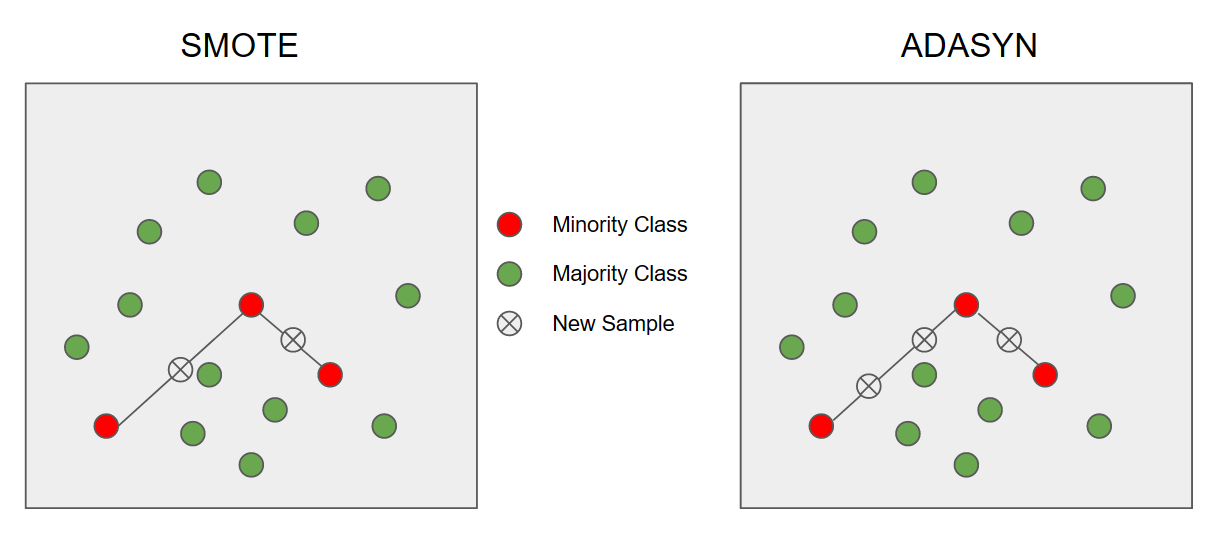

In [50]:
Image("Img/sampling.PNG")

##### SMOTE

In [51]:
X_train, X_validation, y_train, y_validation = train_test_split(X_base, Y_encoded, test_size=0.25, stratify=Y_encoded)

In [53]:
random_state = 2024

In [54]:
sm = SMOTE(random_state=random_state, k_neighbors=3)
X_sm_sampling, y_sm_sampling = sm.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'After sampling for target label')

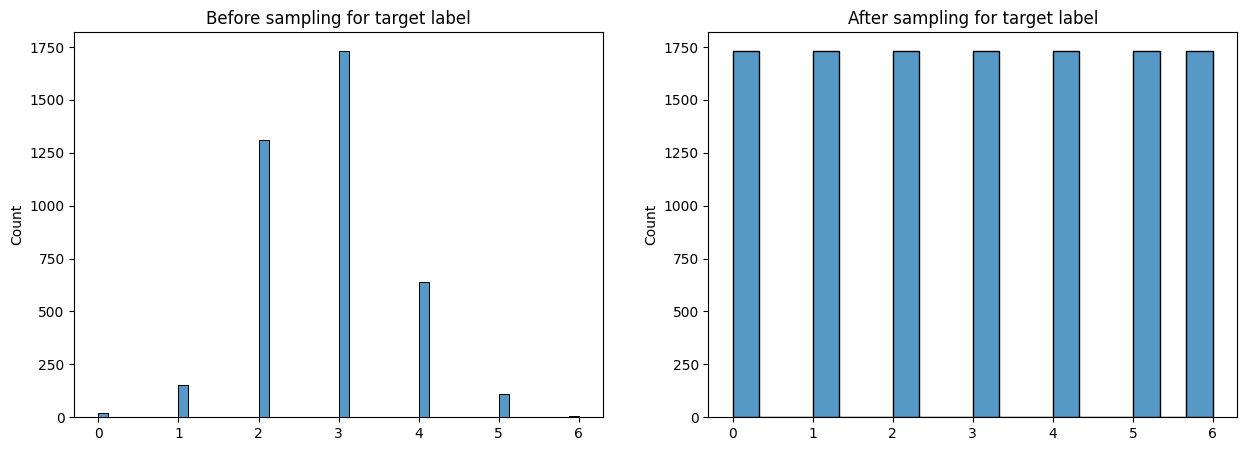

In [55]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.histplot(y_train)
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.histplot(y_sm_sampling)
plt.title("After sampling for target label")

##### ADASYN

In [56]:
ada = ADASYN(random_state=random_state, n_neighbors=3)
X_ada_sampling, y_ada_sampling = ada.fit_resample(X_train, y_train)

Text(0.5, 1.0, 'After sampling for target label')

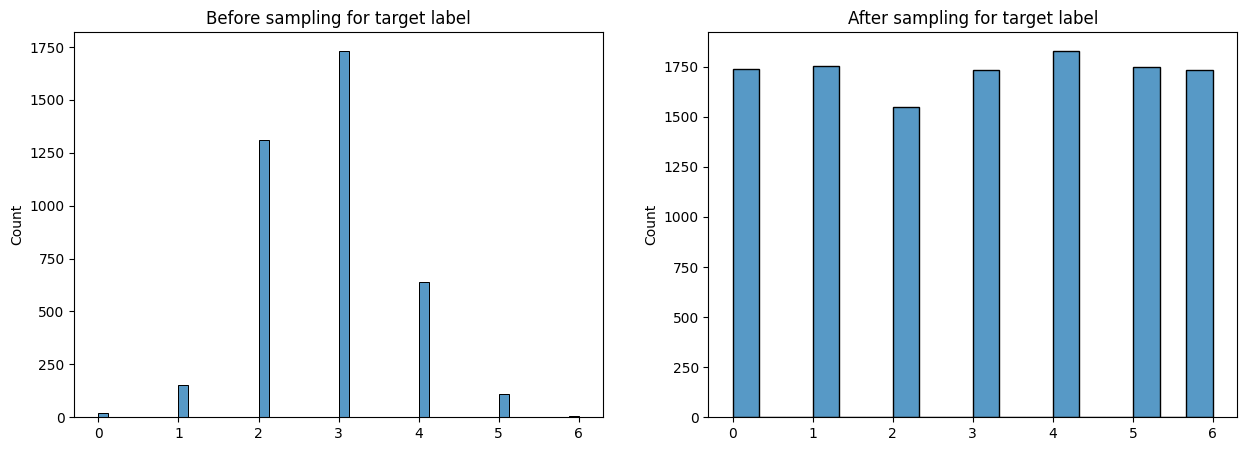

In [57]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(121)
sns.histplot(y_train)
plt.title("Before sampling for target label")

fig.add_subplot(122)
sns.histplot(y_ada_sampling)
plt.title("After sampling for target label")

### 3-3 Summary
##### 총 3개 유형의 feature를 생성 -> model optimization 실험 
1.   No sampling (X_base, Y)
2.   SMOTE oversampling (X_sm_sampling, y_sm_sampling)
3.   ADASYN oversampling (X_sme_sampling, y_sme_sampling)

  

## 4. Model Analysis
1.   base model without sampling
2.   model optimization RandomForest with SMOTE oversampling
3.   model optimization RandomForest with ADASYN oversampling
4.   model optimization xgboost with SMOTE oversampling
5.   model optimization xgboost with ADASYN oversampling
6.   model optimization SVM with SMOTE oversampling
7.   model optimization SVM with ADASYN oversampling

In [58]:
list_model_type = []
list_model_best_params = []
list_model_roc_score = []
cv = 3
n_jobs = -1
n_iter_randomsearch = 40

### 4-1. Base model without sampling

In [59]:
skf = StratifiedKFold(n_splits=3)
skf.get_n_splits(X_base, Y)

3

In [60]:
list_fold_result = []
for i, (train_index, test_index) in enumerate(skf.split(X_base, Y_encoded)):
  X_train_cv, X_test_cv = X_base.iloc[train_index, :], X_base.iloc[test_index, :]
  y_train_cv, y_test_cv = Y_encoded[train_index], Y_encoded[test_index]
  rf_clf = RandomForestClassifier()
  rf_clf.fit(X_train_cv, y_train_cv)
  y_prd = rf_clf.predict(X_test_cv)
  y_prd_proba = rf_clf.predict_proba(X_test_cv)
  prf_score = precision_recall_fscore_support(y_test_cv, y_prd)
  score = roc_auc_score(y_test_cv, y_prd_proba, multi_class="ovr")
  list_fold_result.append(score)
  print(i, " precision, recall, f1score : ", prf_score)
  print(i, " roc_auc_score : ", score)

average_auc = np.mean(list_fold_result)
print("average roc auc score : ",average_auc)
list_model_type.append("Base model without sampling")
list_model_best_params.append({})
list_model_roc_score.append(average_auc)

c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0  precision, recall, f1score :  (array([0.        , 0.26666667, 0.53157122, 0.51343284, 0.53225806,
       0.5       , 0.        ]), array([0.        , 0.05882353, 0.62306368, 0.6692607 , 0.11619718,
       0.02      , 0.        ]), array([0.        , 0.09638554, 0.57369255, 0.58108108, 0.19075145,
       0.03846154, 0.        ]), array([ 10,  68, 581, 771, 284,  50,   1], dtype=int64))
0  roc_auc_score :  0.7443269766201037


c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1  precision, recall, f1score :  (array([0.        , 0.5       , 0.65921788, 0.51056338, 0.43018868,
       0.25      , 0.        ]), array([0.        , 0.01470588, 0.40549828, 0.75324675, 0.40140845,
       0.02040816, 0.        ]), array([0.        , 0.02857143, 0.50212766, 0.60860441, 0.41530055,
       0.03773585, 0.        ]), array([ 10,  68, 582, 770, 284,  49,   2], dtype=int64))
1  roc_auc_score :  0.6953540841252597
2  precision, recall, f1score :  (array([0.        , 0.06654676, 0.50176678, 0.54945055, 0.41237113,
       0.        , 0.        ]), array([0.        , 0.54411765, 0.48797251, 0.38961039, 0.14084507,
       0.        , 0.        ]), array([0.        , 0.11858974, 0.49477352, 0.45592705, 0.20997375,
       0.        , 0.        ]), array([ 10,  68, 582, 770, 284,  49,   2], dtype=int64))
2  roc_auc_score :  0.6618631978053723
average roc auc score :  0.7005147528502452


c:\Users\Jarvis\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

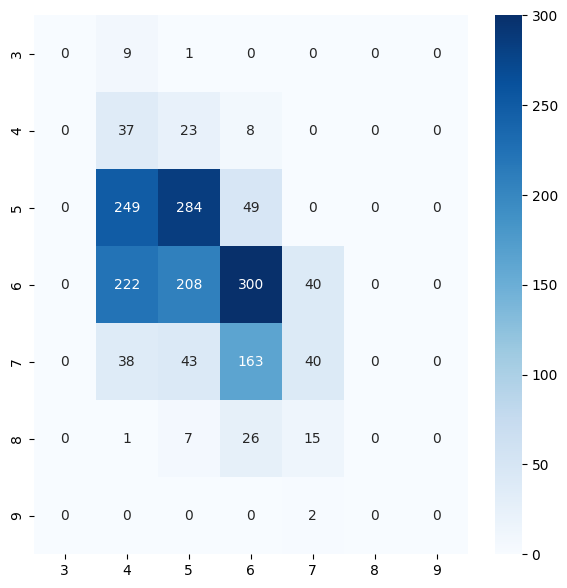

In [61]:
plt.figure(figsize=(7,7))
cm = pd.DataFrame(confusion_matrix(y_test_cv,rf_clf.predict(X_test_cv)), columns=matrix_index, index=matrix_index)
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

### 4-2. Model Optimization RandomForest with SMOTE oversampling

In [62]:
def plot_roc_auc(y_true, y_prd_proba):
  fpr, tpr, _ = roc_curve(y_true,  y_prd_proba)
  auc = roc_auc_score(y_true, y_prd_proba)
  plt.figure(figsize=(7,7))
  plt.plot(fpr,tpr,label="auc="+str(auc))
  plt.legend(loc=4)
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.show()

In [63]:
def model_learning_with_randomsearch(model, hyper_parameter, X, Y, X_validation, Y_validation, metric="roc_auc"):
  random_cv_opt = RandomizedSearchCV(estimator=model, param_distributions=hyper_parameter, n_iter=n_iter_randomsearch, cv = cv, n_jobs = n_jobs, random_state=random_state, scoring=metric, verbose=1)
  random_cv_opt.fit(X, Y)
  y_prd = random_cv_opt.predict(X_validation)
  prf_score = precision_recall_fscore_support(Y_validation, y_prd)
  y_prd_proba = random_cv_opt.predict_proba(X_validation)
  score = roc_auc_score(Y_validation, y_prd_proba, multi_class="ovr")
  print('best model hyper-parameter : ', random_cv_opt.best_params_)
  print("precision, recall, f1score : ", prf_score)
  print("roc_auc_score : ", score)
  return random_cv_opt.best_params_, prf_score, score


In [64]:
hyper_params_rf_randomized = {"max_features" : sp_randInt(8,13),
                              "max_depth" : sp_randInt(6,20),
                              "min_samples_split" : sp_randInt(2,5),
                              "n_estimators" : sp_randInt(15,60),
                              
}
params, prf_score, score = model_learning_with_randomsearch(RandomForestClassifier(), hyper_params_rf_randomized, X_sm_sampling, y_sm_sampling, X_validation, y_validation)
list_model_type.append("Model Optimization RandomForest with SMOTE oversampling")
list_model_best_params.append(params)
list_model_roc_score.append(score)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


### 4-3. Model Optimization RandomForest with ADASYN oversampling

In [65]:
params, prf_score, score = model_learning_with_randomsearch(RandomForestClassifier(), hyper_params_rf_randomized, X_ada_sampling, y_ada_sampling, X_validation, y_validation)
list_model_type.append("Model Optimization RandomForest with ADASYN oversampling")
list_model_best_params.append(params)
list_model_roc_score.append(score)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


### 4-4. model optimization xgboost with SMOTE oversampling


In [ ]:
hyper_params_xgb_randomized = {"min_child_weight" : sp_randInt(3,10),
                              "max_depth" : sp_randInt(6,20),
                              "n_estimators" : sp_randInt(15,60),
                              "learning_rate" : np.linspace(0.1, 2, 7),
                              'subsample': np.linspace(0.4, 1, 5)                              
}
params, prf_score, score = model_learning_with_randomsearch(XGBClassifier(), hyper_params_xgb_randomized, X_sm_sampling, y_sm_sampling, X_validation, y_validation)
list_model_type.append("Model Optimization xgboost with SMOTE oversampling")
list_model_best_params.append(params)
list_model_roc_score.append(score)

### 4-5. model optimization xgboost with ADASYN oversampling





In [ ]:
params, prf_score, score = model_learning_with_randomsearch(XGBClassifier(), hyper_params_xgb_randomized, X_ada_sampling, y_ada_sampling, X_validation, y_validation)
list_model_type.append("Model Optimization xgboost with ADASYN oversampling")
list_model_best_params.append(params)
list_model_roc_score.append(score)

### 4-6. model optimization SVC with SMOTE oversampling

In [ ]:
hyper_params_svc_randomized = {"kernel" : ["linear", "poly", "sigmoid"],
                              "gamma" : ["scale", "auto"],
                               "probability" : [True]                           
}
params, prf_score, score = model_learning_with_randomsearch(SVC(), hyper_params_svc_randomized, X_sm_sampling, y_sm_sampling, X_validation, y_validation)
list_model_type.append("Model Optimization SVC with SMOTE oversampling")
list_model_best_params.append(params)
list_model_roc_score.append(score)

### 4-7. model optimization SVC with ADASYN oversampling

In [ ]:
params, prf_score, score = model_learning_with_randomsearch(SVC(), hyper_params_svc_randomized, X_ada_sampling, y_ada_sampling, X_validation, y_validation)
list_model_type.append("Model Optimization SVC with ADASYN oversampling")
list_model_best_params.append(params)
list_model_roc_score.append(score)

In [ ]:
df_metric = pd.DataFrame({'Model':list_model_type, 'roc_auc_score':list_model_roc_score})
ax = df_metric.plot.barh(x='Model', y='roc_auc_score', rot=0, figsize=(10,10), legend=False)
for bar in ax.patches:
    ax.annotate(format(bar.get_width(), '.4f'),
                   (bar.get_width(), bar.get_y() + bar.get_height() / 2), 
                   size=15, xytext=(8, 0),
                   textcoords='offset points')

### 4-8. Model Analysis
*   Model Optimization xgboost with SMOTE oversampling



In [ ]:
for index in range(len(list_model_best_params)):
  print(list_model_type[index])
  print(list_model_best_params[index])

In [ ]:
# reproduction
xgb_clf = XGBClassifier(**{'learning_rate': 1.05, 'max_depth': 12, 'min_child_weight': 8, 'n_estimators': 27, 'subsample': 1.0})
xgb_clf.fit(X_sm_sampling, y_sm_sampling)
plot_importance(xgb_clf)

In [ ]:
plt.figure(figsize=(7,7))
y_prd = xgb_clf.predict(X_validation)
cm = pd.DataFrame(confusion_matrix(y_validation, y_prd), columns=matrix_index, index=matrix_index)
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d')

Precision and Recall
*   Precision : 모델이 True라고 분류한 것중에서 실제 True 인것의 비중 (TP/(TP+FP))
*   Recall : 실제 True 중에서 모델이 True로 예측한 것의 비중 (TP/(TP+FN))
*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html



In [ ]:
print(precision_recall_fscore_support(y_validation, y_prd, average='micro'))
print(precision_recall_fscore_support(y_validation, y_prd, average='macro'))